In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from typing import List, Dict, Any, Tuple

In [3]:
from tqdm.autonotebook import tqdm, trange

In [4]:
import inflect
number_lexicalizer = inflect.engine()
number_lexicalizer.number_to_words(99)

'ninety-nine'

In [5]:
number_lexicalizer.number_to_words(1099)

'one thousand and ninety-nine'

In [6]:
# # Set up LaTeX fonts
# #plt.style.use(['no-latex'])
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams['text.usetex'] = True
# #plt.rcParams['text.latex.unicode'] = True
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Verdana']})
rc('text', usetex=True)

In [7]:
from toolz import pipe, compose_left

In [9]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings

# load an embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

In [10]:
number_strings_lexical_1_100 = [
    "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
    "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen",
    "nineteen", "twenty", "twenty one", "twenty two", "twenty three", "twenty four", "twenty five",
    "twenty six", "twenty seven", "twenty eight", "twenty nine", "thirty", "thirty one", "thirty two",
    "thirty three", "thirty four", "thirty five", "thirty six", "thirty seven", "thirty eight", "thirty nine",
    "forty", "forty one", "forty two", "forty three", "forty four", "forty five", "forty six", "forty seven",
    "forty eight", "forty nine", "fifty", "fifty one", "fifty two", "fifty three", "fifty four", "fifty five",
    "fifty six", "fifty seven", "fifty eight", "fifty nine", "sixty", "sixty one", "sixty two", "sixty three",
    "sixty four", "sixty five", "sixty six", "sixty seven", "sixty eight", "sixty nine", "seventy", "seventy one",
    "seventy two", "seventy three", "seventy four", "seventy five", "seventy six", "seventy seven", "seventy eight",
    "seventy nine", "eighty", "eighty one", "eighty two", "eighty three", "eighty four", "eighty five", "eighty six",
    "eighty seven", "eighty eight", "eighty nine", "ninety", "ninety one", "ninety two", "ninety three", "ninety four",
    "ninety five", "ninety six", "ninety seven", "ninety eight", "ninety nine", "one hundred"
]

In [11]:
number_integers = [i for i in range(1, 11)]

number_strings = [str(i) for i in number_integers]

number_strings_lexical = [
    "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"
]

number_strings_roman = [
    "i.", "ii.", "ii.", "iv.", "v.", "vi,", "vii", "viii", "ix", "x"
]


In [7]:
# number_dict: Dict[int, Dict[str, Any]] = {
#     i: {
#         "integer": i,
#         "string": str(i),
#         "lexicalized": number_strings_lexical[i]
#     }
#     for i in range(10)
# }

In [12]:
embedding_dict: Dict[int, Dict[str, np.array]] = {
    i: {
        "string": model.encode([str(i - 1)])[0],
        "lexicalized": model.encode([number_strings_lexical[i - 1]])[0],
        "roman": model.encode([number_strings_roman[i - 1]])[0]
    }
    for i in number_integers
}

In [13]:
number_embeddings = np.array(
    [
        embedding_dict[i]["string"] for i in number_integers
    ]
)

In [14]:
number_lexical_embeddings = np.array(
    [
        embedding_dict[i]["lexicalized"] for i in number_integers
    ]
)

In [15]:
number_roman_embeddings = np.array(
    [
        embedding_dict[i]["roman"] for i in number_integers
    ]
)

In [16]:
def compute_RDM(embeddings: np.array, 
                metric: str = 'euclidean') -> np.array:
    """
    Compute the representational dissimilarity matrix (RDM) for a set of representations.
    """
    n = len(embeddings)

    RDM = np.zeros((n, n))
    
    if metric == 'euclidean':
        
        # TODO: vectorize this
        # however using loops seems to be more readable
        for i in range(n):
            for j in range(n):
                RDM[i, j] = np.linalg.norm(
                    embeddings[i] - embeddings[j]
                )

    elif metric == 'linear':
        for i in range(n):
            for j in range(n):
                RDM[i, j] = abs(embeddings[i] - embeddings[j])

    return RDM #/ np.max(RDM)

In [17]:
x = compute_RDM(number_integers)#[0, 1:]

In [18]:
y = compute_RDM(number_roman_embeddings)#[0, 1:]

In [19]:
len(number_integers)

10

In [20]:
import matplotlib.pyplot as plt


plt.scatter(transform_representation(x), transform_representation(y))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot')
plt.show()


NameError: name 'transform_representation' is not defined

In [21]:
def plot_RDM(repr_view: np.array, 
             metric: str = 'euclidean',
             labels: List[str] = None,
             title: str = None,
             with_annotations=True,
             with_ticklabels=True) -> None:
    """
    Plot a representational dissimilarity matrix (RDM).
    """
    RDM = compute_RDM(repr_view, metric)
    np.fill_diagonal(RDM, np.nan)

    m = len(repr_view)/ 10

    plt.figure(figsize=(5, 5))
    sns.heatmap(
        RDM, 
        cmap='Spectral_r', 
        xticklabels=labels, 
        yticklabels=labels, 
        linewidths=0.0,
        linecolor='white',
        annot=with_annotations,
        fmt=".2f",
        cbar=False,
        annot_kws={"fontsize":9},
    ).collections[0].cmap.set_bad('0.9')

    plt.title(title)
    if with_ticklabels:
        plt.yticks(rotation=0, size=12)
        plt.xticks(rotation=0, size=12)

    else:
        plt.xticks([])
        plt.yticks([])

    plt.yticks(rotation=0, size=12)
    plt.xticks(rotation=0, size=12)
    plt.show()

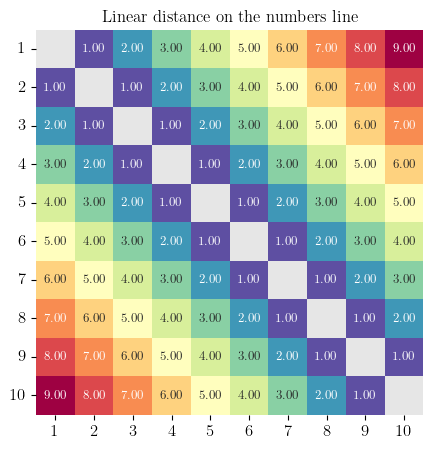

In [22]:
plot_RDM(
    number_integers, 
    metric='linear', 
    labels=number_integers, 
    title='Linear distance on the numbers line'
)

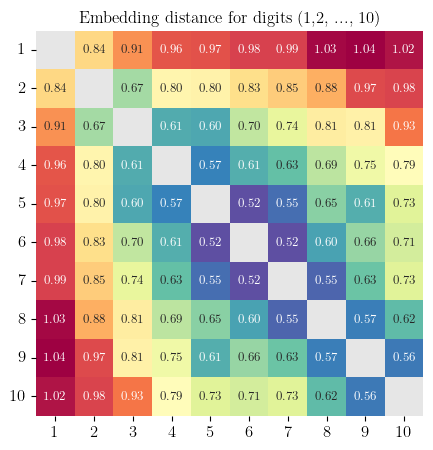

In [23]:
plot_RDM(
    number_embeddings, 
    metric='euclidean', 
    labels=number_integers, 
    title='Embedding distance for digits (1,2, ..., 10)'
)

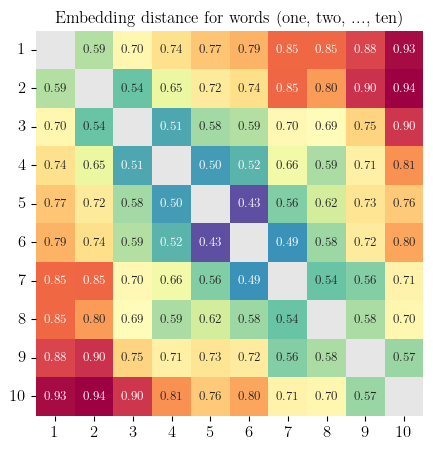

In [24]:
plot_RDM(
    number_lexical_embeddings, 
    metric='euclidean', 
    labels=number_integers, 
    title='Embedding distance for words (one, two, ..., ten)'
)

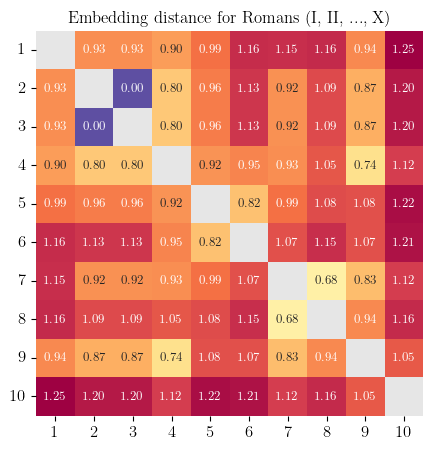

In [25]:
plot_RDM(
    number_roman_embeddings, 
    metric='euclidean', 
    labels=number_integers, 
    title='Embedding distance for Romans (I, II, ..., X)',
    with_annotations=True
)

In [26]:
number_1_100_embeddings = [model.encode(str(i))  for i in range(1, 101)]

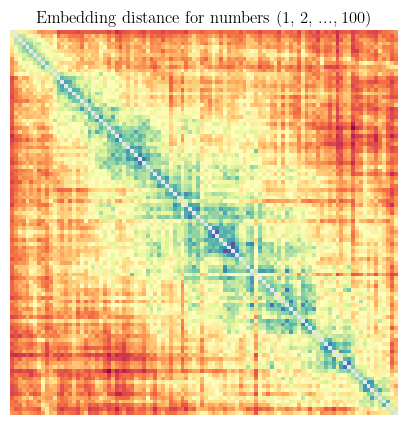

In [27]:
plot_RDM(
    number_1_100_embeddings, 
    metric='euclidean', 
    labels=number_integers, title='Embedding distance for numbers (1, 2, ..., 100)',
    with_annotations=False,
    with_ticklabels=False
)

In [35]:
number_lexical_1_100_embeddings =  model.encode(number_strings_lexical_1_100)
number_lexical_1_100_embeddings.shape

(100, 384)

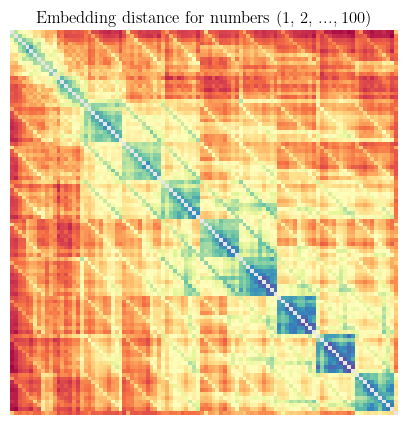

In [36]:
plot_RDM(
    number_lexical_1_100_embeddings, 
    metric='euclidean', 
    labels=number_integers, title='Embedding distance for numbers (1, 2, ..., 100)',
    with_annotations=False,
    with_ticklabels=False
)

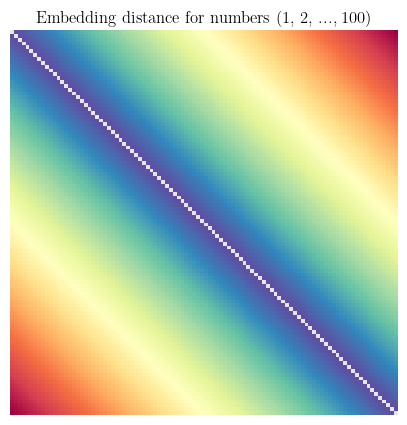

In [279]:
plot_RDM(
    [i for i in range(1, 101)], 
    metric='euclidean', 
    labels=number_integers, title='Embedding distance for numbers (1, 2, ..., 100)',
    with_annotations=False,
    with_ticklabels=False
)

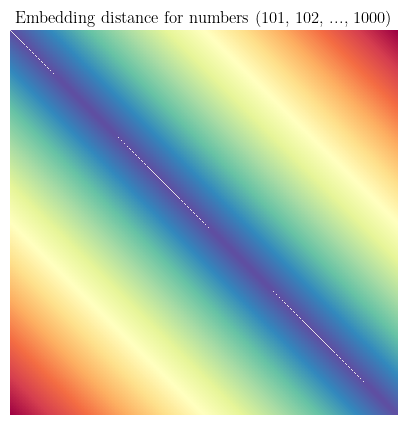

In [37]:
number_int_101_1000 = [i  for i in range(101, 1001)]

plot_RDM(
    number_int_101_1000, 
    metric='linear', 
    labels=number_integers, title='Embedding distance for numbers (101, 102, ..., 1000)',
    with_annotations=False,
    with_ticklabels=False

)

In [38]:
number_lex_101_1000 = [
    number_lexicalizer.number_to_words(i) for i in range(101, 1001)
]

number_lex_101_1000_embeddings = model.encode(number_lex_101_1000)


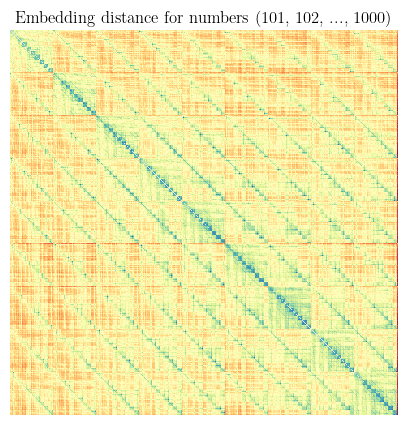

In [39]:
plot_RDM(
    number_lex_101_1000_embeddings, 
    metric='euclidean', 
    labels=number_integers, title='Embedding distance for numbers (101, 102, ..., 1000)',
    with_annotations=False,
    with_ticklabels=False
)

In [40]:
number_str_101_1000 = [str(i) for i in range(101, 1001)]

number_str_101_1000_embeddings = model.encode(number_str_101_1000)

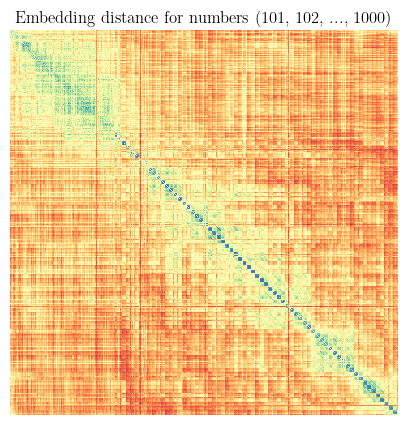

In [41]:
plot_RDM(
    number_str_101_1000_embeddings, 
    metric='euclidean', 
    labels=number_integers, title='Embedding distance for numbers (101, 102, ..., 1000)',
    with_annotations=False,
    with_ticklabels=False
)

In [43]:
def get_matrix_upper_triangle(A: np.ndarray) -> np.ndarray:
    """
    Get the upper triangle values of a 2D matrix A, excluding the diagonal.
    Return a 1D array.
    """
    # get the indices of the upper triangle, excluding the diagonal
    row_indices, col_indices = np.triu_indices(A.shape[0], k=1)

    # extract the upper triangle values
    upper_triangle_values = A[row_indices, col_indices]

    # convert to a matrix (reshaping if necessary)
    #upper_triangle_matrix = upper_triangle_values.reshape(-1, 1)

    return upper_triangle_values

In [44]:
# create a pipeline to transform a representation
transform_representation = compose_left(
    compute_RDM, 
    get_matrix_upper_triangle
)

vec_RDM_ref = transform_representation(number_int_101_1000, metric='linear')
vec_RDM_1 = transform_representation(number_str_101_1000_embeddings, metric='euclidean')
vec_RDM_2 = transform_representation(number_lex_101_1000_embeddings, metric='euclidean')
#vec_RDM_3 = transform_representation(number_roman_embeddings, metric='euclidean')

In [47]:
spearmanr(vec_RDM_ref, vec_RDM_1), spearmanr(vec_RDM_ref, vec_RDM_2)

(SignificanceResult(statistic=np.float64(0.5411303854332616), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.3324802506772513), pvalue=np.float64(0.0)))

In [260]:
vec_RDM_1_b = transform_representation(
    quantize_embeddings(number_str_101_1000_embeddings, precision='binary'), 
    metric='euclidean'
)

vec_RDM_2_b = transform_representation(
    quantize_embeddings(number_lex_101_1000_embeddings, precision='binary'), 
    metric='euclidean'
)

In [261]:
spearmanr(vec_RDM_ref, vec_RDM_1_b), spearmanr(vec_RDM_ref, vec_RDM_2_b)

(SignificanceResult(statistic=np.float64(0.13652545975041694), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.15607455191013342), pvalue=np.float64(0.0)))

In [126]:
# plt.imshow(RDM_1, cmap='Spectral')
# plt.colorbar()
# plt.show()

In [19]:
# RDM_2 = compute_RDM(number_embeddings, metric='euclidean')

# np.fill_diagonal(RDM_2, np.nan)

# plt.imshow(RDM_2, cmap='Spectral')
# plt.colorbar()
# plt.show()

In [21]:
get_matrix_upper_triangle(compute_RDM(number_integers, metric='euclidean'))

array([1., 2., 3., 4., 5., 6., 7., 8., 9., 1., 2., 3., 4., 5., 6., 7., 8.,
       1., 2., 3., 4., 5., 6., 7., 1., 2., 3., 4., 5., 6., 1., 2., 3., 4.,
       5., 1., 2., 3., 4., 1., 2., 3., 1., 2., 1.])

In [22]:
transform_representation = compose_left(
    compute_RDM, 
    get_matrix_upper_triangle
)

In [23]:
# create a pipeline to transform a representation
transform_representation = compose_left(
    compute_RDM, 
    get_matrix_upper_triangle
)

vec_RDM_ref = transform_representation(number_integers, metric='linear')
vec_RDM_1 = transform_representation(number_embeddings, metric='euclidean')
vec_RDM_2 = transform_representation(number_lexical_embeddings, metric='euclidean')
vec_RDM_3 = transform_representation(number_roman_embeddings, metric='euclidean')

In [46]:
from scipy.stats import pearsonr, spearmanr

In [26]:
spearmanr(vec_RDM_ref, vec_RDM_1)

SignificanceResult(statistic=np.float64(0.25209647391950035), pvalue=np.float64(0.09479470446379257))

In [27]:
spearmanr(vec_RDM_ref, vec_RDM_2)

SignificanceResult(statistic=np.float64(0.889963826819647), pvalue=np.float64(2.93475419935858e-16))

In [28]:
spearmanr(vec_RDM_ref, vec_RDM_3)

SignificanceResult(statistic=np.float64(0.4603674577890585), pvalue=np.float64(0.0014621937799900472))